# Simulating IoT Data for Adventure Works Cycles

In [57]:
import pandas as pd
import numpy as np
import uuid
import geopy
from geopy.distance import VincentyDistance

df = pd.read_csv("../data/AW_helmet_customerData.csv", encoding = 'iso-8859-1')
df.head()

,ProductKey,CustomerKey,OrderDateKey,ShipDateKey,LastName,FirstName,BirthDate,MaritalStatus,Gender,YearlyIncome,...,AddressLine2,City,StateProvinceCode,StateProvinceName,CountryRegionCode,EnglishCountryRegionName,PostalCode,DateFirstPurchase,CommuteDistance,SalesOrderNumber
0,222,12131,20040412,20040419,Dominguez,Randall,10/17/1955,M,M,90000,...,NaN,Dunkerque,59,Nord,FR,France,59140,8/24/2001,2-5 Miles,SO68134
1,222,13235,20030822,20030829,Robinson,Jonathan,9/22/1948,M,M,60000,...,NaN,Woodburn,OR,Oregon,US,United States,97071,8/22/2003,10+ Miles,SO52951
2,222,11195,20040424,20040501,Henderson,Megan,2/10/1946,M,F,60000,...,NaN,Renton,WA,Washington,US,United States,98055,10/16/2003,10+ Miles,SO68921
3,222,15292,20040406,20040413,Bailey,Megan,6/17/1971,S,F,60000,...,NaN,Woodburn,OR,Oregon,US,United States,97071,4/6/2004,1-2 Miles,SO67722
4,222,25767,20031220,20031227,Hill,Bailey,10/22/1968,S,F,100000,...,NaN,Tacoma,WA,Washington,US,United States,98403,12/20/2003,0-1 Miles,SO60438


## Add GeoCodes to addresses

First step: we need to format the address in a way that can be read by the online geocoding services.

In [43]:
def formataddress(x, hastwo):
    address = ''
    if hastwo:
        address = x['AddressLine1'].strip() + x['AddressLine2'].strip()
    else:
        address = x['AddressLine1'] 
    address += ',' +  x['City'] + ',' + x['StateProvinceName'] + ','+ x['EnglishCountryRegionName']
    
    return address

    

df['fulladdress'] = df[['AddressLine1','AddressLine2', 'City','StateProvinceName','EnglishCountryRegionName']].apply( lambda x: formataddress(x,True) if(pd.notnull(x['AddressLine2'])) else formataddress(x,False), axis = 1)

### Get Address from Google geocoder

My original GoogleAPI key only allows for 1000 queries per day, so I broke this up over three days and then joined the results together after doing all the queries.

In [5]:
from geopy.geocoders import GoogleV3
geolocator=GoogleV3(api_key='<GoogleAPIKey goes here>')
location = geolocator.geocode(df['fulladdress'][224])
location

Location((-37.8127572, 144.8614765, 0.0))

In [6]:
def getlocation(x,index):
    from time import sleep
    sleep(0.2)
    lat = 0.0
    lon = 0.0
    location = None
    
    try:
        location = geolocator.geocode(x['fulladdress'])
    except:
        print('Problem with row {}... trying again'.format(index))
        location = None
    
    if location == None:
        try:
            location = geolocator.geocode(x['City'] + ',' + x['StateProvinceName'] + x['EnglishCountryRegionName'])
        except:
            print('Double Problem')
            location = geolocator.geocode(x['EnglishCountryRegionName'])
        
        if location == None:
            print('Row: {} - None'.format(index))
        else:
            lat = location.latitude +  (np.random.rand()-0.5)/50.
            lon = location.longitude + (np.random.rand()-0.5)/50.
            print('Row: {} - '.format(index) + location.address)
    else:
        lat = location.latitude 
        lon = location.longitude
        print('Row: {} - '.format(index) + location.address)
    
    return (index, lat, lon)
    
locations = []

for index, row in df1.iterrows():
    locations.append(getlocation(row,index))
    break

# Uncomment to save the queried locations
#locationDF = pd.DataFrame(locations)
# locationDF.to_csv('../data/GeoCodeLocations_sub.csv')

Row: 0 - 244 Rue des Rosiers, 59279 Loon-Plage, France


I already downloaded all the geocode locations and saved them in a csv file.

In [49]:
locationDF = pd.read_csv("../data/GeoCodeLocations.csv")

df_withLocations = df.join(locationDF)
df_withLocations.drop(['index','fulladdress'],axis=1,inplace=True)
df_withLocations.head()

,ProductKey,CustomerKey,OrderDateKey,ShipDateKey,LastName,FirstName,BirthDate,MaritalStatus,Gender,YearlyIncome,...,StateProvinceCode,StateProvinceName,CountryRegionCode,EnglishCountryRegionName,PostalCode,DateFirstPurchase,CommuteDistance,SalesOrderNumber,lat,lon
0,222,12131,20040412,20040419,Dominguez,Randall,10/17/1955,M,M,90000,...,59,Nord,FR,France,59140,8/24/2001,2-5 Miles,SO68134,50.997385,2.209403
1,222,13235,20030822,20030829,Robinson,Jonathan,9/22/1948,M,M,60000,...,OR,Oregon,US,United States,97071,8/22/2003,10+ Miles,SO52951,47.542459,-122.261830
2,222,11195,20040424,20040501,Henderson,Megan,2/10/1946,M,F,60000,...,WA,Washington,US,United States,98055,10/16/2003,10+ Miles,SO68921,47.482876,-122.187895
3,222,15292,20040406,20040413,Bailey,Megan,6/17/1971,S,F,60000,...,OR,Oregon,US,United States,97071,4/6/2004,1-2 Miles,SO67722,47.676868,-122.130536
4,222,25767,20031220,20031227,Hill,Bailey,10/22/1968,S,F,100000,...,WA,Washington,US,United States,98403,12/20/2003,0-1 Miles,SO60438,48.057027,-122.169433


Visualize where the customers are.

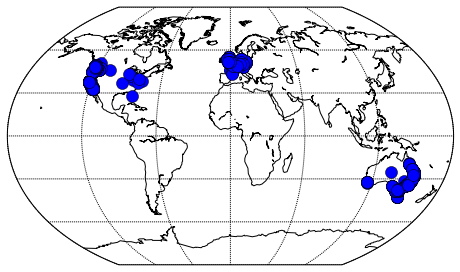

In [30]:
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,6)
# lon_0 is central longitude of projection.
# resolution = 'c' means use crude resolution coastlines.
m = Basemap(projection='kav7',lon_0=0,resolution='c')
m.drawcoastlines()
#m.fillcontinents(color='coral',lake_color='aqua')
# draw parallels and meridians.
m.drawparallels(np.arange(-90.,120.,30.))
m.drawmeridians(np.arange(0.,360.,60.))
#m.drawmapboundary(fill_color='aqua')
x,y = m(df_withLocations['lon'].values, df_withLocations['lat'].values)

m.plot(x, y, 'bo', markersize=12)


# Define New Data Columns

Define a 'first use' date: a minimum of 3 days shipping plus a gamma random number with a peak at 5 (as seen above).

I also want a "lifetime" - how long is the customer going to use their helmet? This is parameterized as:

- firstUse: the date of first usage of the helmet
- finalUse: the date of last usage (which may be modified if there is a severe crash during a trip)
- lastTimeUsed: an updated date on the last time that the helmet was used- will be updated until it equals the finalUse date


In [50]:
df_withLocations['shipDate'] = pd.to_datetime(df['ShipDateKey'],format='%Y%m%d')
df_withLocations['firstUse'] = df_withLocations['shipDate'].apply(lambda x: x + pd.DateOffset(days= 3 + np.random.gamma(5)))
df_withLocations['lastTimeUsed'] = df_withLocations['firstUse']
df_withLocations['finalUse'] = df_withLocations['firstUse'].apply(lambda x: x + pd.DateOffset(days= 365.0*np.random.gamma(4)))

### Define User Average Parameters

- avgSpeed: the average speed for a given user
- consistency: how consistent are the speeds for each step for the user
- distanceParameter: a number that will be the seed for determing how far a given trip will be (even though the trip will be randomized). The higher the distanceParamter, the longer the average trips.
- freqParamter: a number that seeds the next start time calculation. The higher the freqParamter, the shorter the average interval between trips taken for a given user.


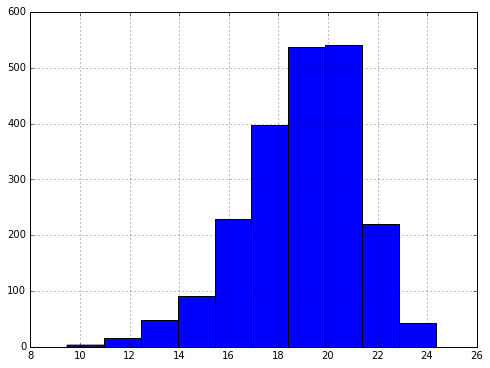

In [51]:
df_withLocations['avgSpeed'] = df_withLocations['shipDate'].apply(lambda x: 20* np.random.weibull(10))
df_withLocations['avgSpeed'].hist()

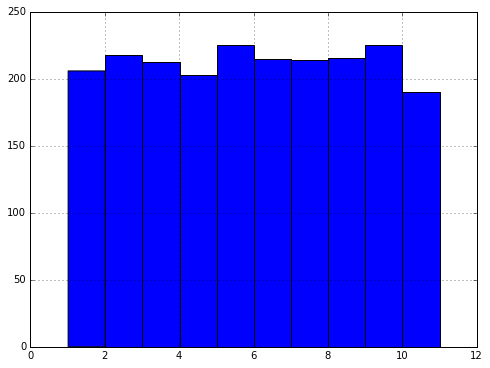

In [52]:
df_withLocations['consistency'] = df_withLocations['shipDate'].apply(lambda x: 10*np.random.random()+1)
df_withLocations['consistency'].hist()

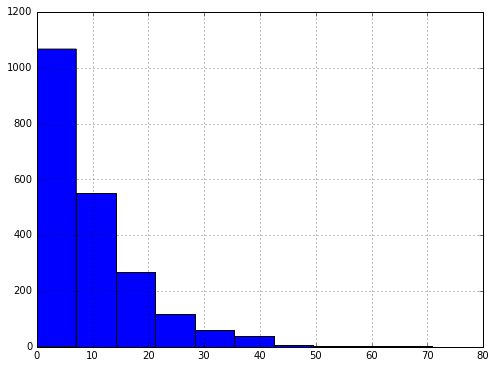

In [53]:
df_withLocations['distanceParameter'] = df_withLocations['shipDate'].apply(lambda x: 10*np.random.exponential())
df_withLocations['distanceParameter'].hist()

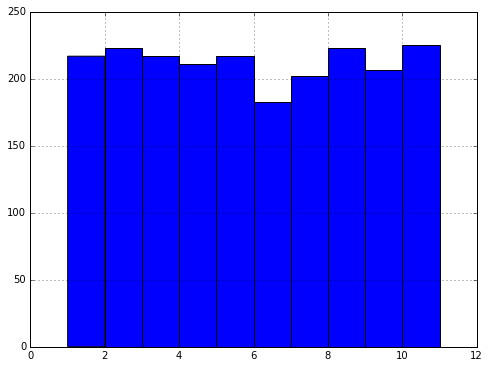

In [54]:
df_withLocations['freqParameter'] = df_withLocations['shipDate'].apply(lambda x: 10*np.random.random()+1)
df_withLocations['freqParameter'].hist()

Ok, next step: building a random walk. I know the delta T (10 seconds) and the velocity comes from the weibull distribution. I need a direction and then need to get the coordinates of the next point. I also need to get then entire trip distance (from the poisson distribution) and stop when I go far enough.

In [79]:
def tripcalculator(x):
    #
    # Caculate a set of steps corresponding to a single trip taken by a single user
    #
    
    # Create unique identifier for the trip
    tripID = str(uuid.uuid4())
    
    # Probability that there is a crash during this trip
    crashprob = 7.0e-5
    
    # Initialize trip variables
    currentDistance = 0
    tripDistance = 0
    
    # Determine how long this trip will be based on the users's distanceParameter
    while tripDistance == 0:
        tripDistance = np.random.poisson(x['distanceParameter']) + 2*np.random.random()-1
    
    # Determine the start time based on a random number given the freqParameter seed.
    starttime = x['lastTimeUsed'] + pd.DateOffset(days=np.random.gamma(x['freqParameter']))

    currenttime = starttime
    deltaTime = 10 #seconds per recording interval

    startlat = x['lat'] + np.random.normal(0.0,0.01) # start offset from home a little bit
    startlon = x['lon'] + np.random.normal(0.0,0.01)

    lat1 = startlat
    lon1 = startlon
    
    # Initialize the array of points with our first point - the start location
    trip_points = [[currenttime.strftime('%Y%m%dT%H:%M:%SZ'),
                    "%.5f" % lat1,
                    "%.5f" % lon1,
                    "%.3f" % 0.0,
                    "%.1f" % 0.0,
                    tripID]]


    tripAvgSpeed = x['avgSpeed'] * np.random.weibull(x['consistency'])
    while tripAvgSpeed > 40:
        tripAvgSpeed = x['avgSpeed'] * np.random.weibull(x['consistency'])
    
    
    # Main look for calculating trip points
    
    hadCrash = False
    while currentDistance < tripDistance and not hadCrash:
        
        # determine step size
        deltax = tripAvgSpeed * np.random.weibull(x['consistency']) * deltaTime/3600 #convert time to hours since speed is in km/h
        
        # get new time based on the deltaTime
        currenttime += pd.DateOffset(seconds=deltaTime)
        
        # Randomize the direction of the step
        bearing = 360*np.random.random() - 180
        # given: lat1, lon1, b = bearing in degrees, d = distance in kilometers

        origin = geopy.Point(lat1, lon1)
        
        # Get the new point based on the distance traveled
        destination = VincentyDistance(kilometers=deltax).destination(origin, bearing)

        #update latitude and longitude
        lat2, lon2 = destination.latitude, destination.longitude

        # Determine if there was a crash (based on distance traveled)
        if np.random.random() < deltax * crashprob:
            hadCrash = True

            injurytype = np.random.random()
            if injurytype < 0.17:
                accel = np.random.uniform(10,20)

            elif injurytype < 0.72:
                accel = np.random.uniform(20,40)

            elif injurytype < 0.93:
                accel = np.random.uniform(30,60)

            else:
                accel = np.random.uniform(40,90)
        else:
            accel = 10*np.random.random()

        # Append to the trip points array
        trip_points.append([currenttime.strftime('%Y%m%dT%H:%M:%SZ'),
                    "%.5f" % lat2,
                    "%.5f" % lon2,
                    "%.3f" % deltax,
                    "%.1f" % accel,
                    tripID])

        currentDistance += deltax
        lat1 = lat2
        lon1 = lon2

    return trip_points

Test the trip simulator:

             DateTime  Latitude   Longitude StepDistance AccelerometerMag  \
0  20040426T10:37:13Z  47.67790  -122.13059        0.000              0.0   
1  20040426T10:37:23Z  47.67755  -122.12918        0.113              6.3   
2  20040426T10:37:33Z  47.67847  -122.12874        0.108              2.8   
3  20040426T10:37:43Z  47.67859  -122.12823        0.041              3.0   
4  20040426T10:37:53Z  47.67966  -122.12804        0.120              8.4   

                                 tripID  
0  72d0f2d9-385b-424a-b9a3-c1f7bf032483  
1  72d0f2d9-385b-424a-b9a3-c1f7bf032483  
2  72d0f2d9-385b-424a-b9a3-c1f7bf032483  
3  72d0f2d9-385b-424a-b9a3-c1f7bf032483  
4  72d0f2d9-385b-424a-b9a3-c1f7bf032483  
Total Dist 27.168, Trip time 1.325,  Average speed 20.5041509434


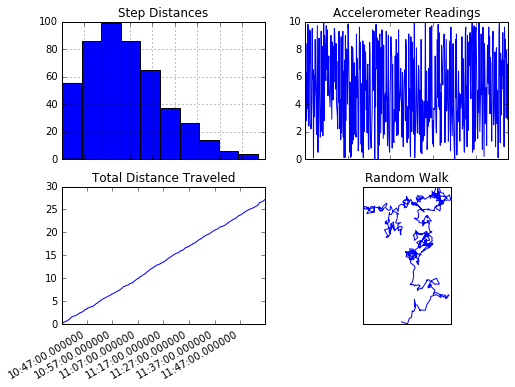

In [85]:
trip1 =pd.DataFrame(tripcalculator(df_withLocations.ix[3]),
                    columns=['DateTime','Latitude','Longitude','StepDistance','AccelerometerMag','tripID'])

print(trip1.head())
trip1['DateTime'] = pd.to_datetime(trip1['DateTime'])
trip1['Latitude'] = pd.to_numeric(trip1['Latitude'])
trip1['Longitude'] = pd.to_numeric(trip1['Longitude'])
trip1['StepDistance'] = pd.to_numeric(trip1['StepDistance'])
trip1['AccelerometerMag'] = pd.to_numeric(trip1['AccelerometerMag'])


f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

# Plot the histogram of step sizes
trip1['StepDistance'].hist(ax=ax1)
ax1.set_title("Step Distances")
tripdistance = trip1['StepDistance'].sum()
triptime = (trip1['DateTime'].tail(1).values[0] - trip1['DateTime'].head(1).values[0])/ np.timedelta64(1, 'h')

print("Total Dist {0}, Trip time {2},  Average speed {1}".format(tripdistance,tripdistance/triptime,triptime))

# Plot the accelerometer readings
trip1['AccelerometerMag'].plot(ax=ax2)
ax2.set_title("Accelerometer Readings")

ax3.plot(trip1['DateTime'].values,trip1['StepDistance'].cumsum().values)
f.autofmt_xdate()
ax3.set_title("Total Distance Traveled")

from matplotlib.patches import Polygon

# Draw the map based on the maximum and minimum positions of our data points
m = Basemap(llcrnrlon=trip1['Longitude'].min(),
            llcrnrlat=trip1['Latitude'].min(),
            urcrnrlon=trip1['Longitude'].max(),
            urcrnrlat=trip1['Latitude'].max(),
        projection='merc')

m.plot(trip1['Longitude'].values,trip1['Latitude'].values, latlon=True,ax=ax4)
ax4.set_title("Random Walk")

In [ ]:
#Run through each person and calculate all of their trips.
numClients = len(df_withLocations)

for k in range(numClients):
    
    # Each set of trips will be stored in a file - we'll need to combine all of them at some future time
    iotID = '_{}_'.format(df2['CustomerKey'][k])+ df2['SalesOrderNumber'][k] + '_{}'.format(df2['ProductKey'][k])
    
    
    # Will continue to run until the lastTimeUsed parameter is larger than the finalUse parameter
    # This means that the data could be re-loaded and run in batches from the continuously updated
    # updatedCustomerDatabase.csv file
    
    if df_withLocations['finalUse'][k] > df_withLocations['lastTimeUsed'][k]:
        with open('../data/tripdata/data_' + iotID + '.csv', 'w') as csvfile:

            filewriter = csv.writer(csvfile, delimiter=',', quoting=csv.QUOTE_MINIMAL,lineterminator='\n')

            filewriter.writerow(['DateTime',
                                 'Latitude',
                                 'Longitude',
                                 'StepDistance',
                                 'AccelerometerMag',
                                 'tripID'])

            ntrips = 0
            while df_withLocations['finalUse'][k] > df_withLocations['lastTimeUsed'][k]:

                ntrips += 1
                newtrip = tripcalculator(df_withLocations.ix[k])

                if newtrip:
                    filewriter.writerows(newtrip)
                    df_withLocations['lastTimeUsed'][k] = pd.to_datetime(newtrip[-1][0])
                    if float(newtrip[-1][4]) > 30:
                        # we had a bad crash, therefore we're not going to use the helmet any more
                        df_withLocations['finalUse'][k] = df_withLocations['lastTimeUsed'][k]
                else:
                    #We've had our final trip and adjust the last use datetime.
                    df_withLocations['finalUse'][k] = df_withLocations['lastTimeUsed'][k]
                if ntrips%10 == 0:
                    daysremaining =  (df_withLocations['finalUse'][k] - df_withLocations['lastTimeUsed'][k])/ np.timedelta64(1, 'D')
                    print("Number of Trips {0}: elapsed time {1}: remaining days {2}".format(ntrips,time()-timestep,daysremaining))

                    timestep = time()

        clear_output()
        print("Customer {0}, elapsed time {1}".format(k, time()-start))
        df_withLocations.to_csv('../data/updatedCustomerDatabase.csv',index=False)
    